In [1]:
import sys
import os
import numpy as np
import numpy.fft as fourier

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline

def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.transpose(img0))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.transpose(img1))
    sub1.set_title(title1)

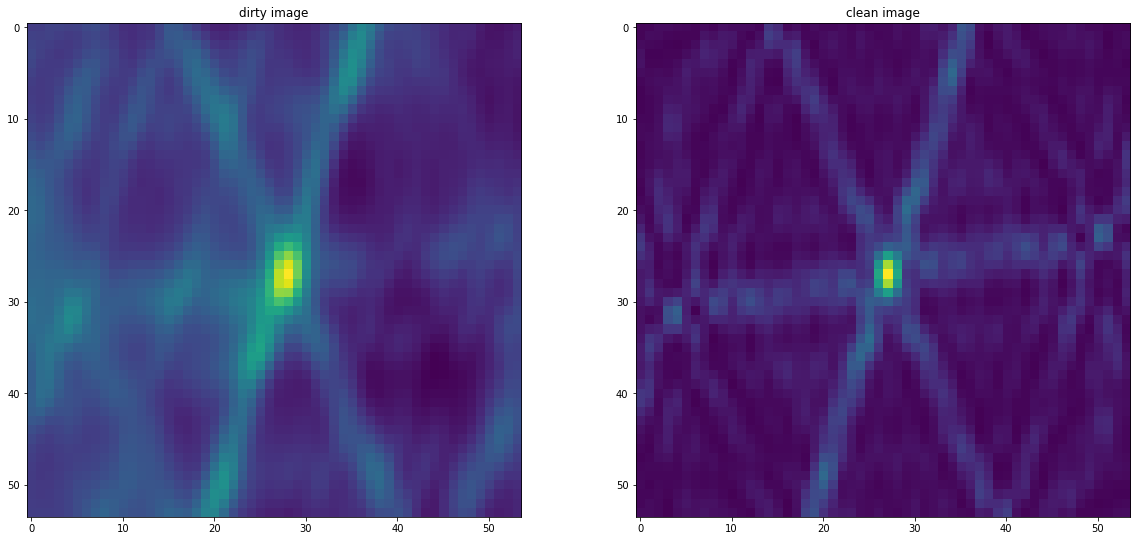

In [2]:
folder = "./img-csv/54x54pixels/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',')
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',')
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',')

plot_comparison(dirty_map, 'dirty image', clean_map, 'clean image')

***

## Dirty Map Reconstruction with gurobi

$minimize \left \| D_b - x \right \|_2^2$

In [ ]:
dirty_flat = dirty_map.flatten()
m = Model("dirty-reconstruction")

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar(lb=-GRB.INFINITY))
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += (x0[i] - dirty_flat[i])*(x0[i] - dirty_flat[i])

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in m.getVars()], dirty_map.shape)
del m
del obj

In [ ]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "reconstruction")

***
## Reconstruction with PSF

$minimize \left \| D_b - x * PSF \right \|_2^2$

In [ ]:
D_FT = fourier.fft2(dirty_map)
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

PSF_FT = fourier.fft2(psf_map)
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

In [ ]:
model = Model("dirty-psf")

x0_real = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
x0_imag = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)

objective = QuadExpr()
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        objective += (D_real[i, j] - x0_real[i, j] * PSF_real[i, j]) * (D_real[i, j] - x0_real[i, j] * PSF_real[i, j]) #real part
        objective += (D_imag[i, j] - x0_imag[i, j] * PSF_imag[i, j]) * (D_imag[i, j] - x0_imag[i, j] * PSF_imag[i, j]) #imaginary part

model.setObjective(objective, GRB.MINIMIZE)
model.optimize() 

FT_rec = np.zeros(dirty_map.shape, dtype=np.complex128)
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        FT_rec[i, j] = x0_real[i, j].x  + x0_imag[i, j].x * 1j

reconstruction = fourier.ifft2(FT_rec).real
del model
del objective

In [ ]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "fft reconstruction")

### Second try

In [3]:
D_FT = fourier.fft2(dirty_map)
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

PSF_FT = fourier.fft2(psf_map)
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

dimension = dirty_map.shape[0]* dirty_map.shape[0]

f_cos= []
f_sin= []

for u in range(0, dirty_map.shape[0]):
    u_index = u * dirty_map.shape[0]
    for v in range(0, dirty_map.shape[1]):
        cos_row = {}
        sin_row = {}
        for i in range(0, dirty_map.shape[0]):
            index = i * dirty_map.shape[0]
            for j in range(0, dirty_map.shape[1]):
                cos_row[index+j] = math.cos(-2*math.pi*(i*u/dirty_map.shape[0] + j*v/dirty_map.shape[1]))
                sin_row[index+j] = math.sin(-2*math.pi*(i*u/dirty_map.shape[0] + j*v/dirty_map.shape[1]))
        f_cos.append(cos_row)
        f_sin.append(sin_row)

In [18]:
model = Model("dirty-psf2")

x0 = model.addVars(dirty_map.shape[0]*dirty_map.shape[1], lb=-GRB.INFINITY)

objective = QuadExpr()
for u in range(0, 1):
    uv_index = u* dirty_map.shape[0]
    for v in range(0, 1):
        real = x0.prod(f_cos[uv_index + v])
        #imag = x0.prod(f_sin[uv_index + v])
        objective += (D_real[u,v] - real) * (D_real[u,v] - real)
        #objective += (D_imag[u,v] - imag) * (D_imag[u,v] - imag)
    print("u done "+ str(u))
        
model.setObjective(objective, GRB.MINIMIZE)

u done 0


In [19]:

model.optimize()

reconstruction_dirty2 = np.reshape([var.x for var in model.getVars()], dirty_map.shape)

Optimize a model with 0 rows, 2916 columns and 0 nonzeros
Model has 4252986 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [8e+03, 8e+03]
  QObjective range [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 3.35s
Presolved: 0 rows, 2916 columns, 0 nonzeros
Presolved model has 4252986 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2917
 AA' NZ     : 0.000e+00
 Factor NZ  : 1.000e+00 (roughly 1 MByte of memory)
 Factor Ops : 1.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.70537342e+07  1.70537342e+07  0.00e+00 8.26e+03  0.00e+00     6s
   1   1.70537192e+07  1.70537342e+07  1.41e-08 8.26e+03  0.00e+00     6s
   2   1.70537126e+07  1.70537342e+07  3.11e-08 8.26e+03  0.00e+00     6s
   3   1.70537028e+07  1

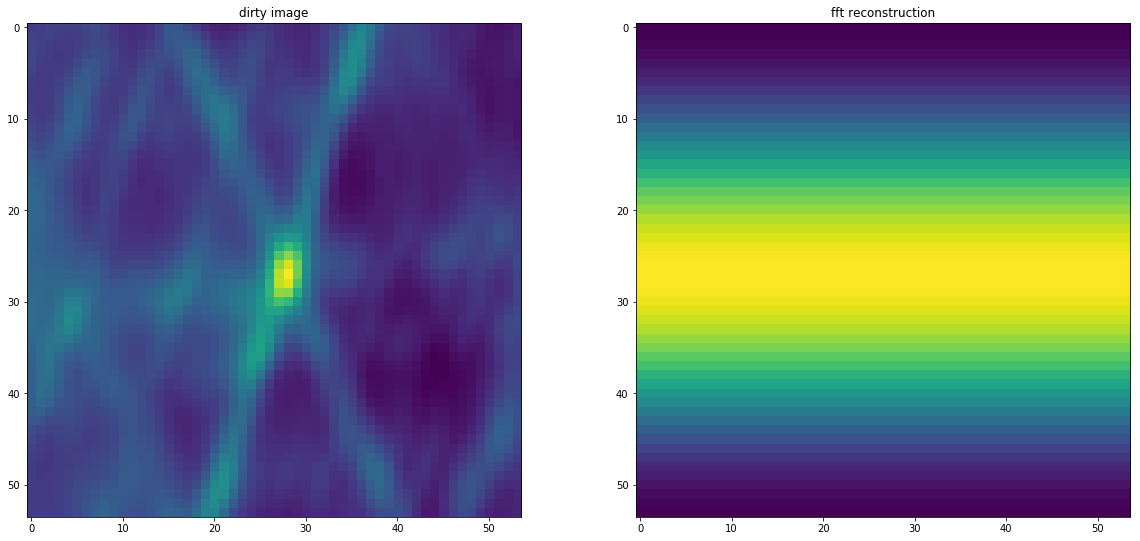

In [17]:
plot_comparison(dirty_map, 'dirty image', reconstruction_dirty2, "fft reconstruction")

In [4]:
model = Model("try")

x0 = model.addVars(dirty_map.shape[0]*dirty_map.shape[1], lb=-GRB.INFINITY)
objective = QuadEpr()

In [10]:
real = x0.prod(f_cos[1])
objective += (D_real[u,v] - real) * (D_real[u,v] - real)

In [12]:
real.getCoeff(1900)

0.3960797660391569

In [77]:
f_cos[0]

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0,
 32: 1.0,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 1.0,
 44: 1.0,
 45: 1.0,
 46: 1.0,
 47: 1.0,
 48: 1.0,
 49: 1.0,
 50: 1.0,
 51: 1.0,
 52: 1.0,
 53: 1.0,
 54: 1.0,
 55: 1.0,
 56: 1.0,
 57: 1.0,
 58: 1.0,
 59: 1.0,
 60: 1.0,
 61: 1.0,
 62: 1.0,
 63: 1.0,
 64: 1.0,
 65: 1.0,
 66: 1.0,
 67: 1.0,
 68: 1.0,
 69: 1.0,
 70: 1.0,
 71: 1.0,
 72: 1.0,
 73: 1.0,
 74: 1.0,
 75: 1.0,
 76: 1.0,
 77: 1.0,
 78: 1.0,
 79: 1.0,
 80: 1.0,
 81: 1.0,
 82: 1.0,
 83: 1.0,
 84: 1.0,
 85: 1.0,
 86: 1.0,
 87: 1.0,
 88: 1.0,
 89: 1.0,
 90: 1.0,
 91: 1.0,
 92: 1.0,
 93: 1.0,
 94: 1.0,
 95: 1.0,
 96: 1.0,
 97: 1.0,
 98: 1.0,
 99: 1.0,
 100: 1.0,

In [54]:
reconstruction_dirty2[0,30]

-5.442909240717223

In [55]:
dirty_map[0,30]

4.676603317260742